In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jp797498e/twitter-entity-sentiment-analysis")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/twitter-entity-sentiment-analysis


In [2]:
!pip install cleantext

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from cleantext import clean
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, BatchNormalization, Dropout
from keras.initializers import Constant
from keras.regularizers import l1, l2
from sklearn.metrics import classification_report, confusion_matrix
sns.set()

2025-04-12 14:44:18.879109: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744469059.108585      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744469059.175840      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
os.listdir('/kaggle/input/twitter-entity-sentiment-analysis')

['twitter_validation.csv', 'twitter_training.csv']

In [5]:
df = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv', header = None)
df.head()

,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [6]:
df.shape

(74682, 4)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       74682 non-null  int64 
 1   1       74682 non-null  object
 2   2       74682 non-null  object
 3   3       73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [8]:
df.isnull().sum()

0      0
1      0
2      0
3    686
dtype: int64

In [9]:
df.rename({2: 'sentiment', 3: 'text'}, axis = 1, inplace = True)

In [10]:
df.head()

,0,1,sentiment,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [11]:
df.apply(pd.isnull).sum()

0              0
1              0
sentiment      0
text         686
dtype: int64

In [12]:
df.dropna(subset = ['text'], inplace = True)

In [13]:
df.isnull().sum()

0            0
1            0
sentiment    0
text         0
dtype: int64

In [14]:
df.shape

(73996, 4)

In [15]:
df.duplicated().sum()

2340

In [16]:
df.drop_duplicates(inplace = True)

In [17]:
df.shape

(71656, 4)

In [18]:
df['sentiment'].value_counts()

sentiment
Negative      21698
Positive      19713
Neutral       17708
Irrelevant    12537
Name: count, dtype: int64

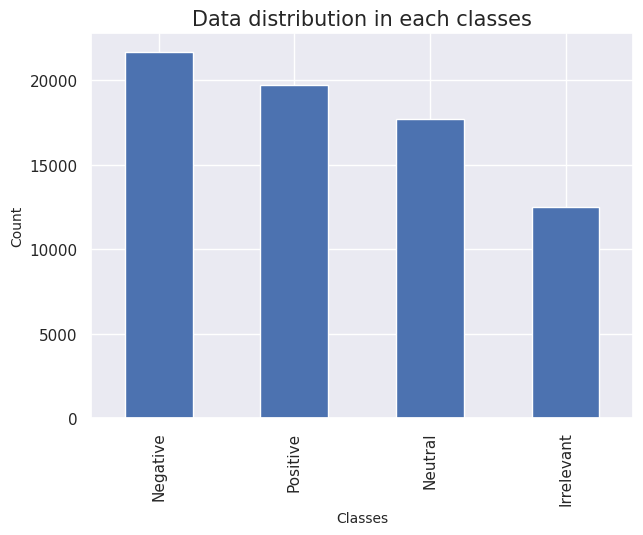

In [19]:
df['sentiment'].value_counts().plot(kind = 'bar', figsize = (7, 5))
plt.title('Data distribution in each classes', fontsize = 15)
plt.xlabel('Classes', fontsize = 10)
plt.ylabel('Count', fontsize = 10)
plt.show()

In [20]:
df1 = df[df['sentiment'] == 'Irrelevant']
df2 = df[df['sentiment'] == 'Neutral'].sample(df1.shape[0], random_state = 101)
df3 = df[df['sentiment'] == 'Positive'].sample(df1.shape[0], random_state = 101)
df4 = df[df['sentiment'] == 'Negative'].sample(df1.shape[0], random_state = 101)

In [21]:
df_b = pd.concat([df1, df2, df3, df4])

In [22]:
df_b.shape

(50148, 4)

In [23]:
df_b.head()

,0,1,sentiment,text
102,2418,Borderlands,Irrelevant,Appreciate the (sonic) concepts / praxis Valen...
103,2418,Borderlands,Irrelevant,Appreciate the (sound) concepts / practices th...
104,2418,Borderlands,Irrelevant,Evaluate the (sound) concepts / concepts of Va...
105,2418,Borderlands,Irrelevant,Appreciate the (sonic) concepts / praxis Valen...
106,2418,Borderlands,Irrelevant,Appreciate by the ( sonic ) electronic concept...


In [24]:
df_b['sentiment'].value_counts()

sentiment
Irrelevant    12537
Neutral       12537
Positive      12537
Negative      12537
Name: count, dtype: int64

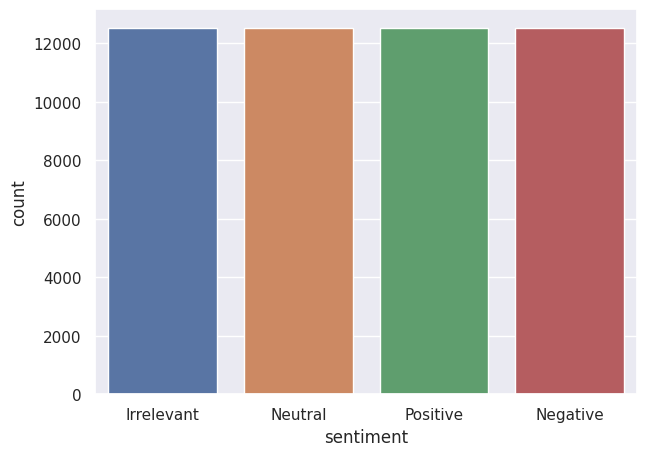

In [25]:
plt.figure(figsize = (7, 5))
sns.countplot(data = df_b, x = 'sentiment')
plt.show()

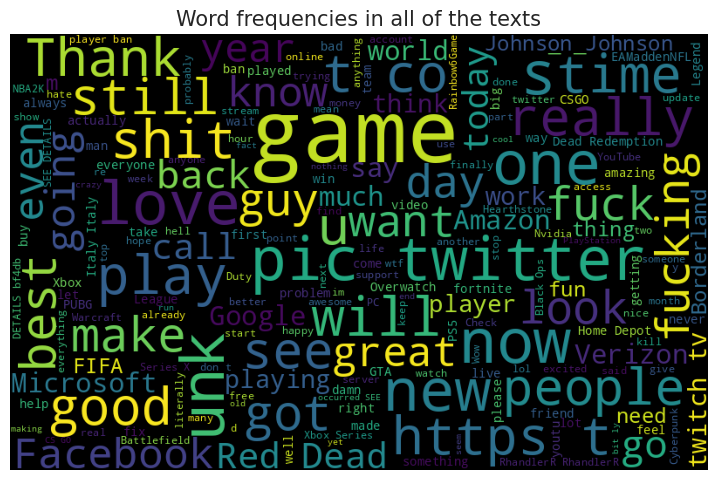

In [26]:
plt.figure(figsize = (9, 7))
all_sents = ' '.join([sentence for sentence in df_b['text']])
word_cloud = WordCloud(width = 800, height = 500, max_font_size = 100, random_state = 101).generate(all_sents)
plt.imshow(word_cloud)
plt.title('Word frequencies in all of the texts', fontsize = 15)
plt.axis('off')
plt.show()

In [27]:
def word_cloud(data, sentiment):
    plt.figure(figsize = (9, 7))
    all_sents = ' '.join([sentence for sentence in data['text'][data['sentiment'] == sentiment]])
    wordcl = WordCloud(width = 800, height = 500, max_font_size = 100, random_state = 101).generate(all_sents)
    plt.imshow(wordcl)
    plt.title(sentiment, fontsize = 15)
    plt.axis('off')
    plt.show()

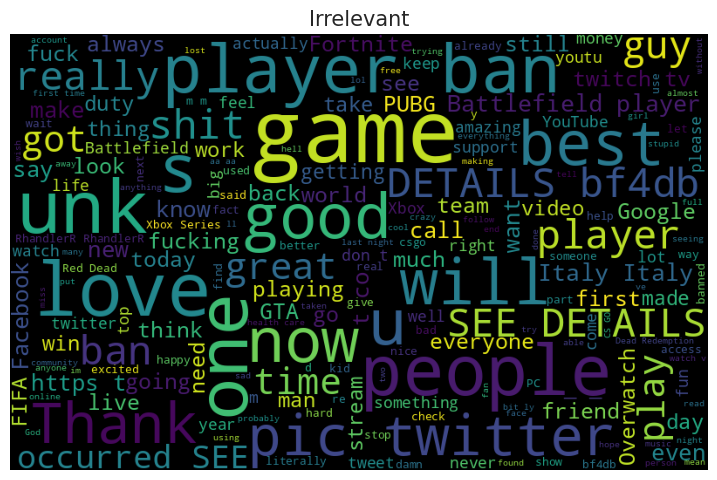

In [28]:
word_cloud(df_b, 'Irrelevant')

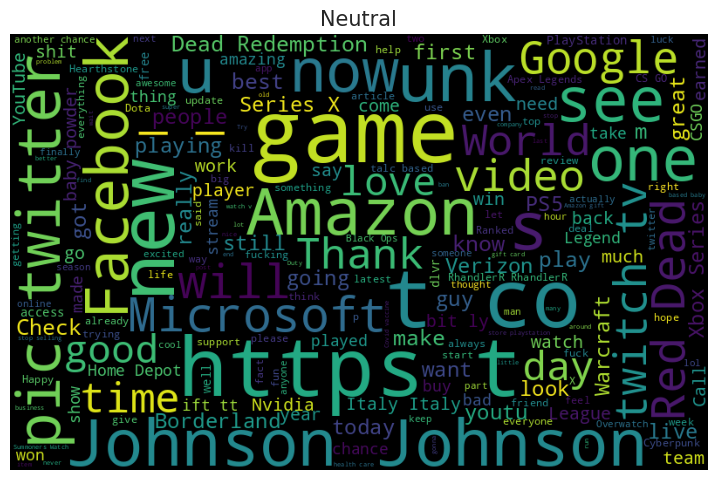

In [29]:
word_cloud(df_b, 'Neutral')

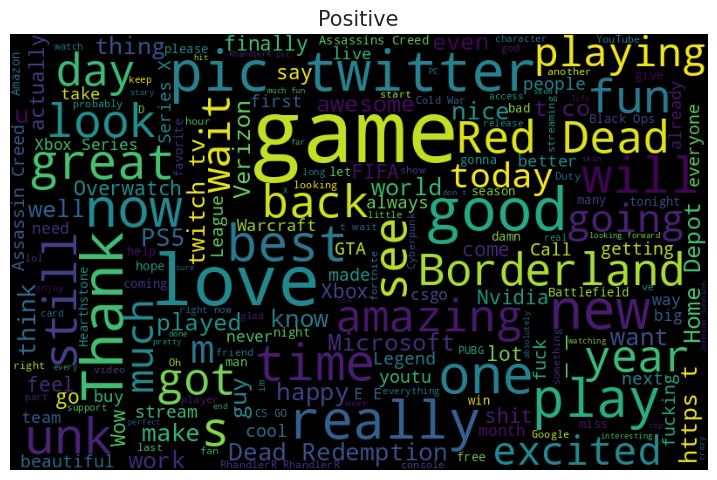

In [30]:
word_cloud(df_b, 'Positive')

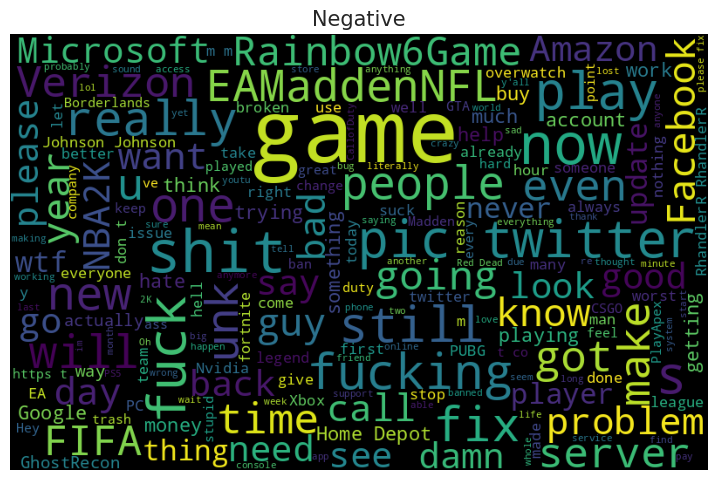

In [31]:
word_cloud(df_b, 'Negative')

In [26]:
df_b['cleaned_text'] = df_b['text'].apply(clean)

In [27]:
df_b.head()

,0,1,sentiment,text,cleaned_text
102,2418,Borderlands,Irrelevant,Appreciate the (sonic) concepts / praxis Valen...,appreci sonic concept praxi valenzuela landapo...
103,2418,Borderlands,Irrelevant,Appreciate the (sound) concepts / practices th...,appreci sound concept practic valenzuela landa...
104,2418,Borderlands,Irrelevant,Evaluate the (sound) concepts / concepts of Va...,evalu sound concept concept valensela landa po...
105,2418,Borderlands,Irrelevant,Appreciate the (sonic) concepts / praxis Valen...,appreci sonic concept praxi valenzuela morenop...
106,2418,Borderlands,Irrelevant,Appreciate by the ( sonic ) electronic concept...,appreci sonic electron concept praxi valenzuel...


In [28]:
df_b.reset_index(drop = True, inplace = True)

In [29]:
df_b.head()

,0,1,sentiment,text,cleaned_text
0,2418,Borderlands,Irrelevant,Appreciate the (sonic) concepts / praxis Valen...,appreci sonic concept praxi valenzuela landapo...
1,2418,Borderlands,Irrelevant,Appreciate the (sound) concepts / practices th...,appreci sound concept practic valenzuela landa...
2,2418,Borderlands,Irrelevant,Evaluate the (sound) concepts / concepts of Va...,evalu sound concept concept valensela landa po...
3,2418,Borderlands,Irrelevant,Appreciate the (sonic) concepts / praxis Valen...,appreci sonic concept praxi valenzuela morenop...
4,2418,Borderlands,Irrelevant,Appreciate by the ( sonic ) electronic concept...,appreci sonic electron concept praxi valenzuel...


In [30]:
df_b['text'][100]

'Making games is a brutally difficult family business. Without the team, you have done nothing. Our industry itself is already very brutally badly underpaid for what little we do when VS others. This is shameful.'

In [31]:
df_b['cleaned_text'][100]

'make game brutal difficult famili busi without team done noth industri alreadi brutal badli underpaid littl vs other shame'

In [32]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_b['cleaned_text'])
seq = tokenizer.texts_to_sequences(df_b['cleaned_text'])

In [33]:
vocab_size = len(tokenizer.word_index) + 1
print(f'Vocab size: {vocab_size}')

Vocab size: 29426


In [34]:
maxlen = max([len(i) for i in seq])
print(f'Max length of sequences: {maxlen}')

Max length of sequences: 163


In [35]:
pad_seq = pad_sequences(seq, maxlen = maxlen, padding = 'post')

In [36]:
le = LabelEncoder()

In [37]:
y = le.fit_transform(df_b['sentiment'])

In [38]:
X = pad_seq

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101, shuffle = True, stratify = y)

In [40]:
print(f'Training set size: {len(X_train)}')
print(f'Test set size: {len(X_test)}')

Training set size: 40118
Test set size: 10030


In [39]:
df_val = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv', header = None)
df_val.head()

,0,1,2,3
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [40]:
df_val.shape

(1000, 4)

In [41]:
df_val.isnull().sum()

0    0
1    0
2    0
3    0
dtype: int64

In [42]:
df_val.duplicated().sum()

0

In [43]:
df_val.rename({2: 'sentiment', 3: 'text'}, axis = 1, inplace = True)

In [44]:
df_val.head()

,0,1,sentiment,text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [45]:
df_val['sentiment'].value_counts()

sentiment
Neutral       285
Positive      277
Negative      266
Irrelevant    172
Name: count, dtype: int64

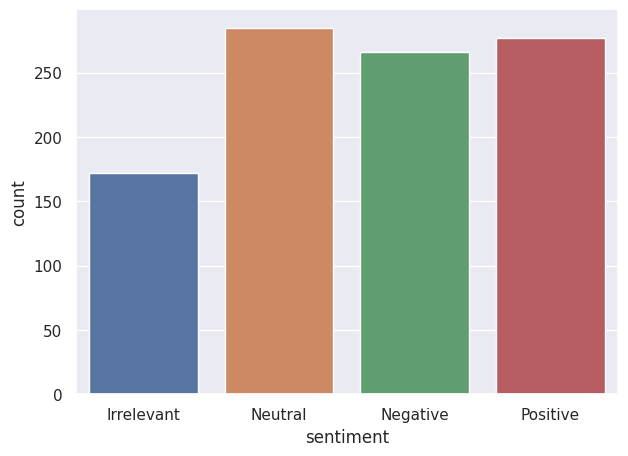

In [48]:
plt.figure(figsize = (7, 5))
sns.countplot(data = df_val, x = 'sentiment')
plt.show()

In [46]:
df_val['cleaned_text'] = df_val['text'].apply(clean)

In [50]:
val_seq = tokenizer.texts_to_sequences(df_val['cleaned_text'])

In [51]:
pad_val = pad_sequences(val_seq, maxlen = maxlen, padding = 'post')

In [52]:
y_val = le.transform(df_val['sentiment'])

In [53]:
X_val = pad_val

In [54]:
le2=  LabelEncoder()

In [55]:
y_2_train = le2.fit_transform(df_b[1])

In [56]:
y_2_val = le2.transform(df_val[1])

In [57]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("anmolkumar/glove-embeddings")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/glove-embeddings


In [58]:
os.listdir('/kaggle/input/glove-embeddings')

['glove.6B.200d.txt',
 'glove.6B.50d.txt',
 'glove.6B.300d.txt',
 'glove.6B.100d.txt']

In [59]:
embedding_matrix = dict()
glove_file = open('/kaggle/input/glove-embeddings/glove.6B.100d.txt', encoding = 'utf8')
for line in glove_file:
    record = line.split()
    word = record[0]
    vector = np.asarray(record[1:], dtype = 'float32')
    embedding_matrix[word] = vector
glove_file.close()

In [60]:
embedding_vectors = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    vec = embedding_matrix.get(word)
    if vec is not None:
        embedding_vectors[index] = vec

In [61]:
embedding_vectors

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.062659  ,  0.026003  ,  1.12199998, ...,  0.46125999,
         0.88780999, -0.031292  ],
       [-0.24078   ,  0.024725  ,  0.64614999, ...,  0.010441  ,
         0.44889   ,  0.53435999],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [62]:
def plot_results(train_losses, train_accs, val_losses, val_accs):
    fig, axes = plt.subplots(1, 2, figsize = (15, 5))
    xs = np.arange(1, len(train_losses) + 1, 1)
    axes[0].plot(xs, train_losses, label = 'Train')
    axes[0].plot(xs, val_losses, label = 'Validation')
    axes[0].set_title('Loss', fontsize = 15)
    axes[0].set_xlabel('Epochs', fontsize = 10)
    axes[0].set_ylabel('Loss', fontsize = 10)
    axes[0].set_xticks(xs)
    axes[1].plot(xs, train_accs, label = 'Train')
    axes[1].plot(xs, val_accs, label = 'Validation')
    axes[1].set_title('Accuracy', fontsize = 15)
    axes[1].set_xlabel('Epoch', fontsize = 10)
    axes[1].set_ylabel('Accuracy', fontsize = 10)
    axes[1].set_xticks(xs)
    plt.tight_layout()
    plt.legend()
    plt.show()

In [69]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 2)

In [70]:
model = Sequential()

In [71]:
model.add(Embedding(vocab_size, 100, embeddings_initializer = Constant(embedding_vectors), trainable = False))
model.add(Bidirectional(LSTM(15)))
model.add(Dense(4, activation = 'softmax'))

I0000 00:00:1744357394.789438      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744357394.790196      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [72]:
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [73]:
history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 100, callbacks = [early_stopping], batch_size = 64)

Epoch 1/100


I0000 00:00:1744357400.465840     104 cuda_dnn.cc:529] Loaded cuDNN version 90300


627/627 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.3613 - loss: 1.3249 - val_accuracy: 0.4730 - val_loss: 1.1910
Epoch 2/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.4710 - loss: 1.1823 - val_accuracy: 0.5160 - val_loss: 1.1132
Epoch 3/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.5060 - loss: 1.1278 - val_accuracy: 0.5490 - val_loss: 1.0635
Epoch 4/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.5177 - loss: 1.1016 - val_accuracy: 0.5570 - val_loss: 1.0379
Epoch 5/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.5370 - loss: 1.0698 - val_accuracy: 0.5730 - val_loss: 1.0128
Epoch 6/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.5486 - loss: 1.0499 - val_accuracy: 0.5790 - val_loss: 0.9794
Epoch 7/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.5599 - loss: 1.0312 - val_accuracy: 0.5950 - val_loss: 0.9542
Epoch 8/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.5688 - loss: 1.0170 - val_accurac

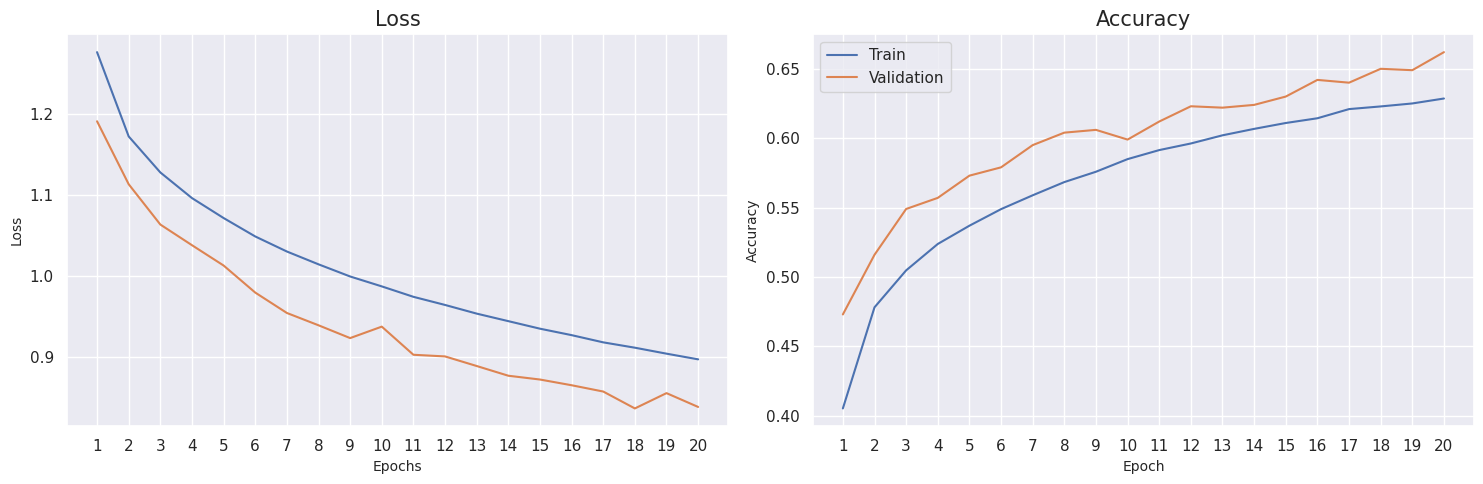

In [74]:
plot_results(history.history['loss'], history.history['accuracy'], history.history['val_loss'], history.history['val_accuracy'])

In [75]:
early_stopping2 = EarlyStopping(monitor = 'val_loss', patience = 2)

In [76]:
model2 = Sequential()

In [77]:
model2.add(Embedding(vocab_size, 100, embeddings_initializer = Constant(embedding_vectors), trainable = False))
model2.add(Bidirectional(LSTM(50)))
model2.add(Dense(4, activation = 'softmax'))

In [78]:
model2.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [79]:
history2 = model2.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 100, callbacks = [early_stopping2], batch_size = 64)

Epoch 1/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.3988 - loss: 1.2768 - val_accuracy: 0.4950 - val_loss: 1.1157
Epoch 2/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.4961 - loss: 1.1363 - val_accuracy: 0.5440 - val_loss: 1.0352
Epoch 3/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.5394 - loss: 1.0636 - val_accuracy: 0.5940 - val_loss: 0.9580
Epoch 4/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.5803 - loss: 0.9847 - val_accuracy: 0.6390 - val_loss: 0.9009
Epoch 5/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.6109 - loss: 0.9268 - val_accuracy: 0.6690 - val_loss: 0.8156
Epoch 6/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.6490 - loss: 0.8589 - val_accuracy: 0.6730 - val_loss: 0.7821
Epoch 7/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.6692 - loss: 0.8098 - val_accuracy: 0.6990 - val_loss: 0.7604
Epoch 8/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.6924 - loss: 0.7608 -

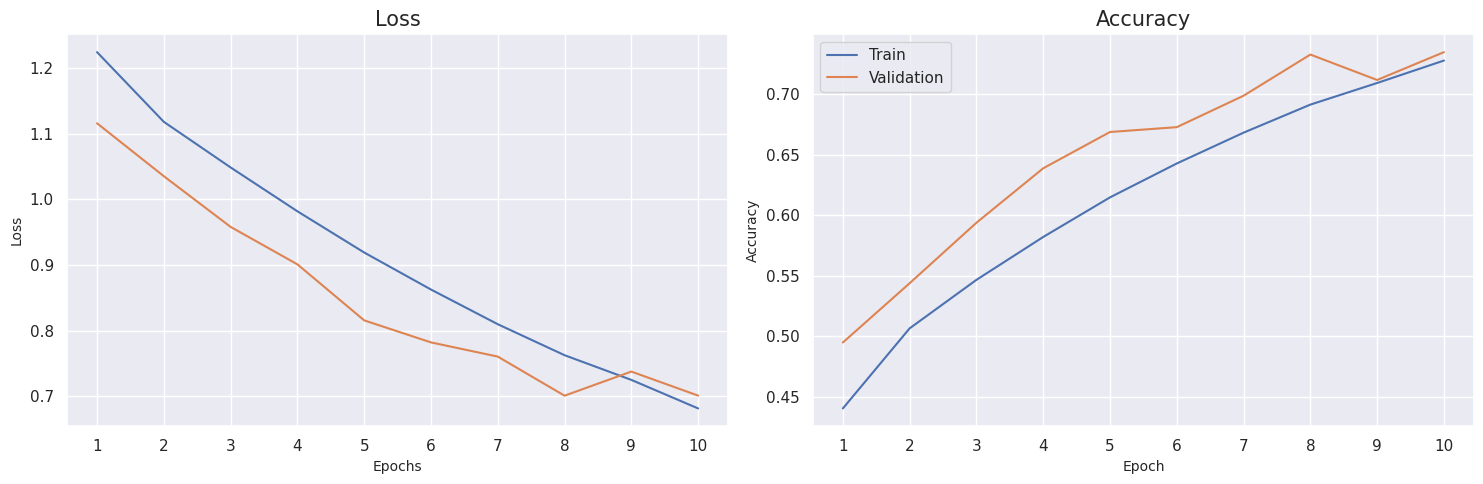

In [80]:
plot_results(history2.history['loss'], history2.history['accuracy'], history2.history['val_loss'], history2.history['val_accuracy'])

In [81]:
early_stopping3 = EarlyStopping(monitor = 'val_loss', patience = 2)

In [82]:
model3 = Sequential()

In [83]:
model3.add(Embedding(vocab_size, 100, embeddings_initializer = Constant(embedding_vectors), trainable = False))
model3.add(Bidirectional(LSTM(25, return_sequences = True)))
model3.add(Bidirectional(LSTM(25)))
model3.add(Dense(4, activation = 'softmax'))

In [84]:
model3.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [85]:
history3 = model3.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 100, callbacks = [early_stopping3], batch_size = 64)

Epoch 1/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.4018 - loss: 1.2824 - val_accuracy: 0.5360 - val_loss: 1.1106
Epoch 2/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.5065 - loss: 1.1236 - val_accuracy: 0.5600 - val_loss: 1.0189
Epoch 3/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.5511 - loss: 1.0510 - val_accuracy: 0.5990 - val_loss: 0.9583
Epoch 4/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.5774 - loss: 0.9934 - val_accuracy: 0.6310 - val_loss: 0.8867
Epoch 5/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.6062 - loss: 0.9418 - val_accuracy: 0.6850 - val_loss: 0.8209
Epoch 6/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.6410 - loss: 0.8785 - val_accuracy: 0.6710 - val_loss: 0.8074
Epoch 7/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.6584 - loss: 0.8360 - val_accuracy: 0.6720 - val_loss: 0.7977
Epoch 8/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.6846 - loss: 0

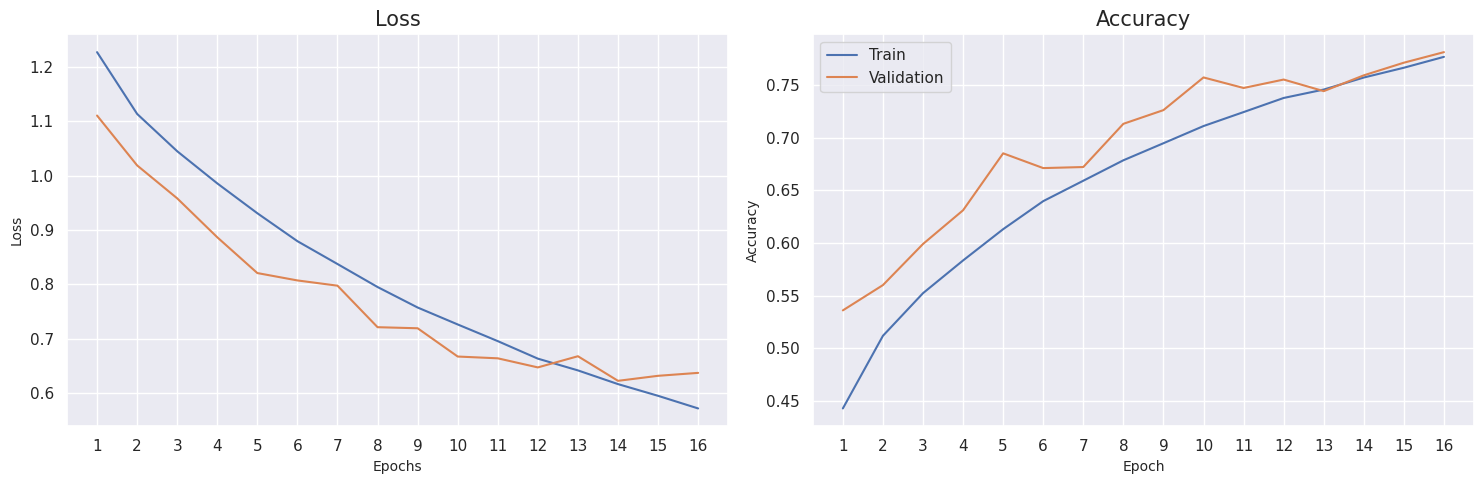

In [86]:
plot_results(history3.history['loss'], history3.history['accuracy'], history3.history['val_loss'], history3.history['val_accuracy'])

In [93]:
early_stopping4 = EarlyStopping(monitor = 'val_loss', patience = 2)

In [94]:
model4 = Sequential()

In [95]:
model4.add(Embedding(vocab_size, 100, embeddings_initializer = Constant(embedding_vectors), trainable = False))
model4.add(Bidirectional(LSTM(100)))
model4.add(Dense(4, activation = 'softmax'))

In [96]:
model4.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [97]:
history4 = model4.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 100, callbacks = [early_stopping4], batch_size = 64)

Epoch 1/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.4110 - loss: 1.2618 - val_accuracy: 0.5220 - val_loss: 1.0884
Epoch 2/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.5111 - loss: 1.1100 - val_accuracy: 0.5880 - val_loss: 0.9871
Epoch 3/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.5762 - loss: 1.0024 - val_accuracy: 0.6390 - val_loss: 0.8769
Epoch 4/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.6276 - loss: 0.8908 - val_accuracy: 0.6700 - val_loss: 0.7907
Epoch 5/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.6832 - loss: 0.7820 - val_accuracy: 0.7350 - val_loss: 0.6895
Epoch 6/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.7276 - loss: 0.6857 - val_accuracy: 0.7620 - val_loss: 0.6330
Epoch 7/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.7608 - loss: 0.6084 - val_accuracy: 0.7970 - val_loss: 0.5602
Epoch 8/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.7948 - loss: 0.5302 -

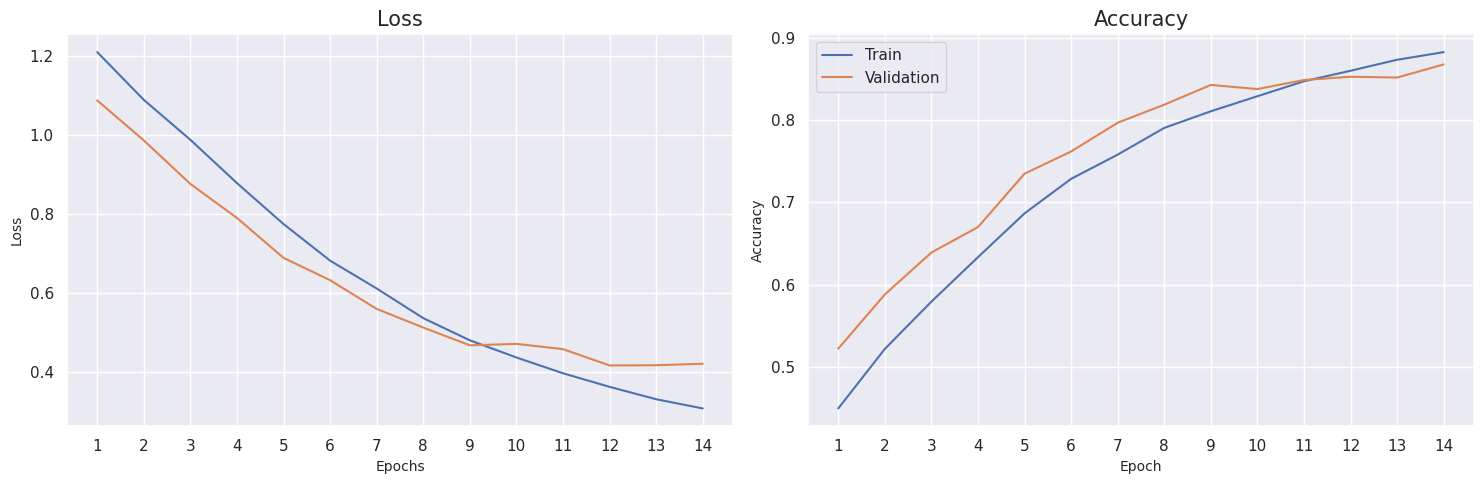

In [98]:
plot_results(history4.history['loss'], history4.history['accuracy'], history4.history['val_loss'], history4.history['val_accuracy'])

In [105]:
early_stopping5 = EarlyStopping(monitor = 'val_loss', patience = 2)

In [106]:
model5 = Sequential()

In [107]:
model5.add(Embedding(vocab_size, 100, embeddings_initializer = Constant(embedding_vectors), trainable = False))
model5.add(Bidirectional(LSTM(200)))
model5.add(Dense(4, activation = 'softmax'))

In [108]:
model5.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [109]:
history5 = model5.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 100, callbacks = [early_stopping5], batch_size = 64)

Epoch 1/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.4098 - loss: 1.2586 - val_accuracy: 0.5300 - val_loss: 1.0779
Epoch 2/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.5205 - loss: 1.0911 - val_accuracy: 0.6140 - val_loss: 0.9212
Epoch 3/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.5909 - loss: 0.9577 - val_accuracy: 0.7090 - val_loss: 0.7539
Epoch 4/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.6490 - loss: 0.8547 - val_accuracy: 0.6930 - val_loss: 0.7741
Epoch 5/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.6889 - loss: 0.7625 - val_accuracy: 0.7780 - val_loss: 0.6001
Epoch 6/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.7699 - loss: 0.5881 - val_accuracy: 0.8150 - val_loss: 0.5093
Epoch 7/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.8178 - loss: 0.4800 - val_accuracy: 0.8270 - val_loss: 0.4722
Epoch 8/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.8171 - loss: 0

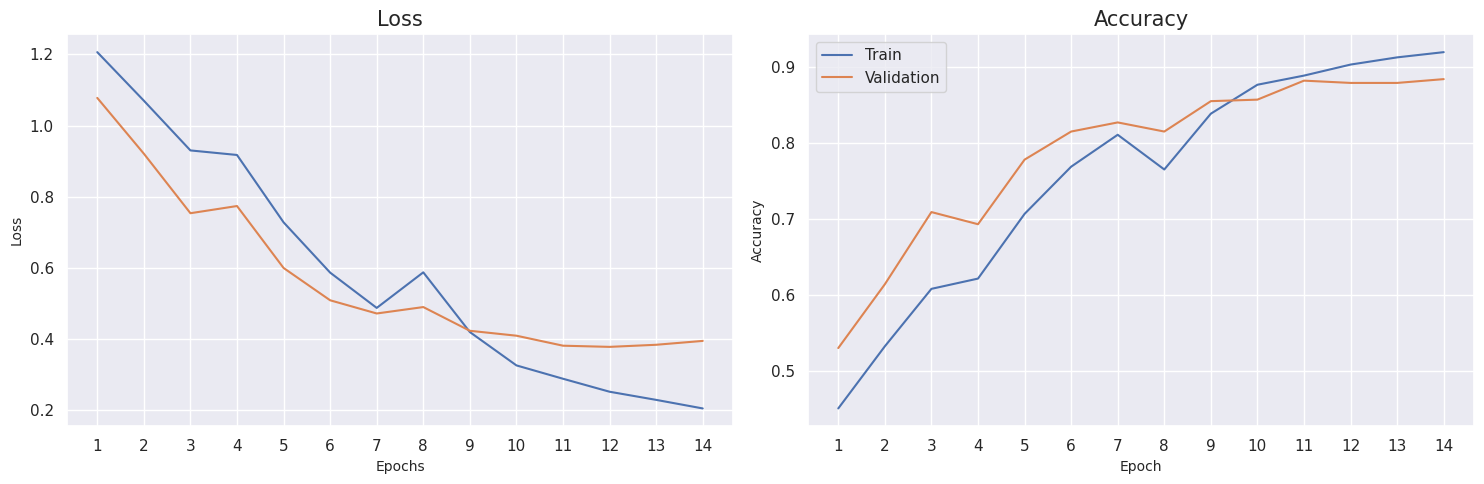

In [110]:
plot_results(history5.history['loss'], history5.history['accuracy'], history5.history['val_loss'], history5.history['val_accuracy'])

In [111]:
early_stopping6 = EarlyStopping(monitor = 'val_loss', patience = 2)

In [112]:
model6 = Sequential()

In [113]:
model6.add(Embedding(vocab_size, 100, embeddings_initializer = Constant(embedding_vectors), trainable = False))
model6.add(Bidirectional(LSTM(300)))
model6.add(Dense(4, activation = 'softmax'))

In [114]:
model6.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [115]:
history6 = model6.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 100, callbacks = [early_stopping6], batch_size = 64)

Epoch 1/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 28s 39ms/step - accuracy: 0.4150 - loss: 1.2562 - val_accuracy: 0.5060 - val_loss: 1.1096
Epoch 2/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.4462 - loss: 1.2473 - val_accuracy: 0.5330 - val_loss: 1.0725
Epoch 3/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.5317 - loss: 1.0686 - val_accuracy: 0.6030 - val_loss: 0.9414
Epoch 4/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.5917 - loss: 0.9595 - val_accuracy: 0.6470 - val_loss: 0.8626
Epoch 5/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.6627 - loss: 0.8206 - val_accuracy: 0.7400 - val_loss: 0.6724
Epoch 6/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.7254 - loss: 0.6778 - val_accuracy: 0.8010 - val_loss: 0.5437
Epoch 7/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.7936 - loss: 0.5291 - val_accuracy: 0.8420 - val_loss: 0.4601
Epoch 8/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.8413 - loss: 0

In [116]:
early_stopping7 = EarlyStopping(monitor = 'val_loss', patience = 2)

In [117]:
model7 = Sequential()

In [118]:
model7.add(Embedding(vocab_size, 100, embeddings_initializer = Constant(embedding_vectors), trainable = False))
model7.add(Bidirectional(LSTM(400)))
model7.add(Dense(7, activation = 'softmax'))

In [119]:
model7.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [120]:
history7 = model7.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 100, callbacks = [early_stopping7], batch_size = 64)

Epoch 1/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 42s 61ms/step - accuracy: 0.3734 - loss: 1.3268 - val_accuracy: 0.5070 - val_loss: 1.1070
Epoch 2/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 36s 57ms/step - accuracy: 0.5113 - loss: 1.1165 - val_accuracy: 0.5940 - val_loss: 0.9618
Epoch 3/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 37s 58ms/step - accuracy: 0.5402 - loss: 1.1287 - val_accuracy: 0.6460 - val_loss: 0.8581
Epoch 4/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - accuracy: 0.6228 - loss: 0.9016 - val_accuracy: 0.6980 - val_loss: 0.7171
Epoch 5/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - accuracy: 0.7064 - loss: 0.7313 - val_accuracy: 0.7250 - val_loss: 0.6952
Epoch 6/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 37s 58ms/step - accuracy: 0.7685 - loss: 0.5887 - val_accuracy: 0.8400 - val_loss: 0.4350
Epoch 7/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 37s 58ms/step - accuracy: 0.8430 - loss: 0.4141 - val_accuracy: 0.8640 - val_loss: 0.3733
Epoch 8/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - accuracy: 0.8852 - loss: 0

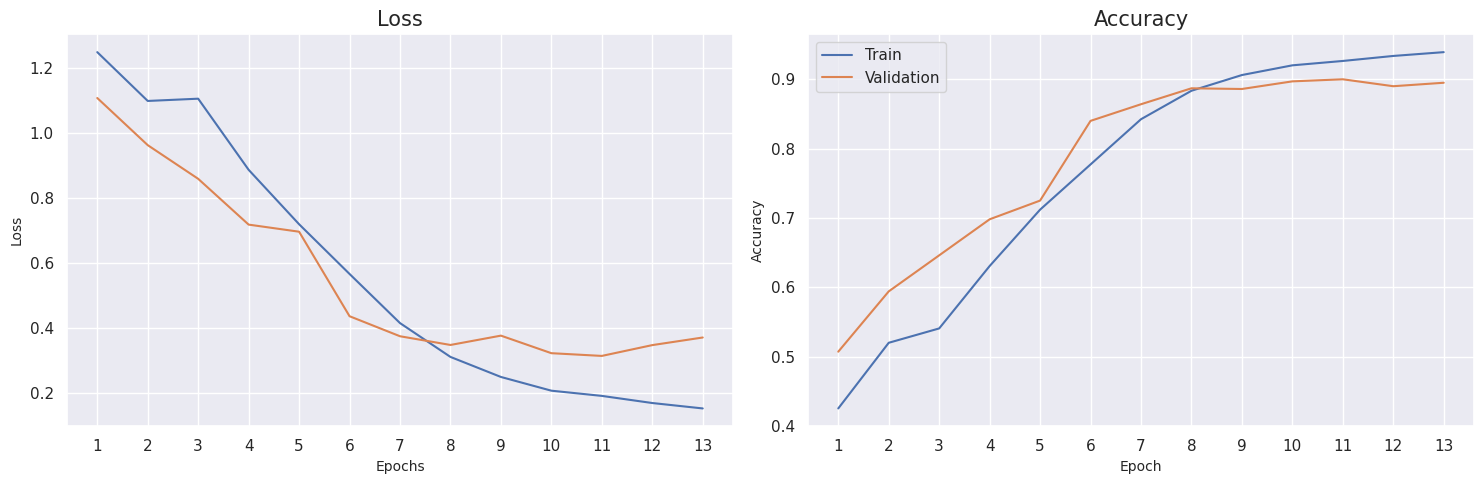

In [121]:
plot_results(history7.history['loss'], history7.history['accuracy'], history7.history['val_loss'], history7.history['val_accuracy'])

In [122]:
early_stopping8 = EarlyStopping(monitor = 'val_loss', patience = 2)

In [123]:
model8 = Sequential()

In [124]:
model8.add(Embedding(vocab_size, 100, embeddings_initializer = Constant(embedding_vectors), trainable = False))
model8.add(Bidirectional(LSTM(100, return_sequences = True)))
model8.add(Bidirectional(LSTM(100, return_sequences = True)))
model8.add(Bidirectional(LSTM(100)))
model8.add(Dense(4, activation = 'softmax'))

In [125]:
model8.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [126]:
history8 = model8.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 100, callbacks = [early_stopping8], batch_size = 64)

Epoch 1/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 42s 53ms/step - accuracy: 0.4183 - loss: 1.2529 - val_accuracy: 0.5450 - val_loss: 1.0634
Epoch 2/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 31s 50ms/step - accuracy: 0.5234 - loss: 1.0891 - val_accuracy: 0.6150 - val_loss: 0.9424
Epoch 3/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 32s 50ms/step - accuracy: 0.5975 - loss: 0.9502 - val_accuracy: 0.6720 - val_loss: 0.8005
Epoch 4/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 32s 51ms/step - accuracy: 0.6697 - loss: 0.8085 - val_accuracy: 0.7240 - val_loss: 0.6970
Epoch 5/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 32s 50ms/step - accuracy: 0.7302 - loss: 0.6691 - val_accuracy: 0.8010 - val_loss: 0.5549
Epoch 6/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 32s 50ms/step - accuracy: 0.7892 - loss: 0.5329 - val_accuracy: 0.8260 - val_loss: 0.4965
Epoch 7/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 32s 50ms/step - accuracy: 0.8332 - loss: 0.4295 - val_accuracy: 0.8380 - val_loss: 0.4424
Epoch 8/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 32s 50ms/step - accuracy: 0.8654 - loss: 0

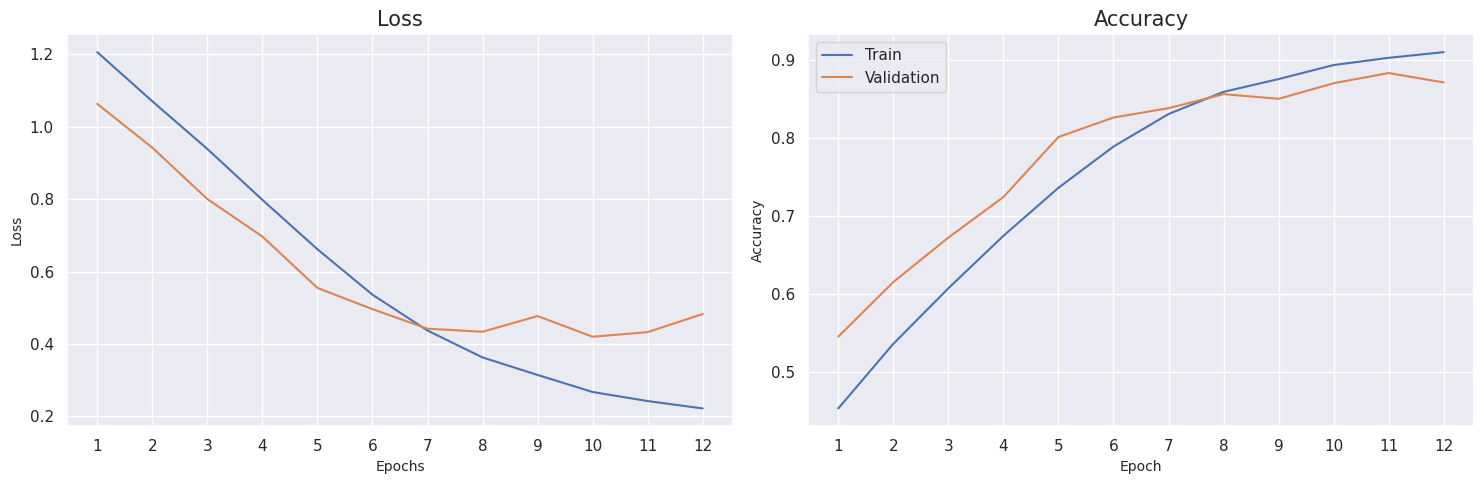

In [127]:
plot_results(history8.history['loss'], history8.history['accuracy'], history8.history['val_loss'], history8.history['val_accuracy'])

In [132]:
early_stopping9 = EarlyStopping(monitor = 'val_loss', patience = 2)

In [133]:
model9 = Sequential()

In [134]:
model9.add(Embedding(vocab_size, 100, embeddings_initializer = Constant(embedding_vectors), trainable = False))
model9.add(Bidirectional(LSTM(300)))
model9.add(Dense(128, activation = 'relu'))
model9.add(Dense(4, activation = 'softmax'))

In [135]:
model9.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [136]:
history9 = model9.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 100, callbacks = [early_stopping9], batch_size = 64)

Epoch 1/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 29s 39ms/step - accuracy: 0.4193 - loss: 1.2509 - val_accuracy: 0.5220 - val_loss: 1.0860
Epoch 2/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.5297 - loss: 1.0726 - val_accuracy: 0.6450 - val_loss: 0.8769
Epoch 3/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.6273 - loss: 0.8864 - val_accuracy: 0.7210 - val_loss: 0.6893
Epoch 4/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.7331 - loss: 0.6687 - val_accuracy: 0.7960 - val_loss: 0.5504
Epoch 5/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - accuracy: 0.8163 - loss: 0.4705 - val_accuracy: 0.8470 - val_loss: 0.4406
Epoch 6/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.8173 - loss: 0.4836 - val_accuracy: 0.8450 - val_loss: 0.4472
Epoch 7/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.8912 - loss: 0.2761 - val_accuracy: 0.8760 - val_loss: 0.4395
Epoch 8/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.9159 - loss: 0

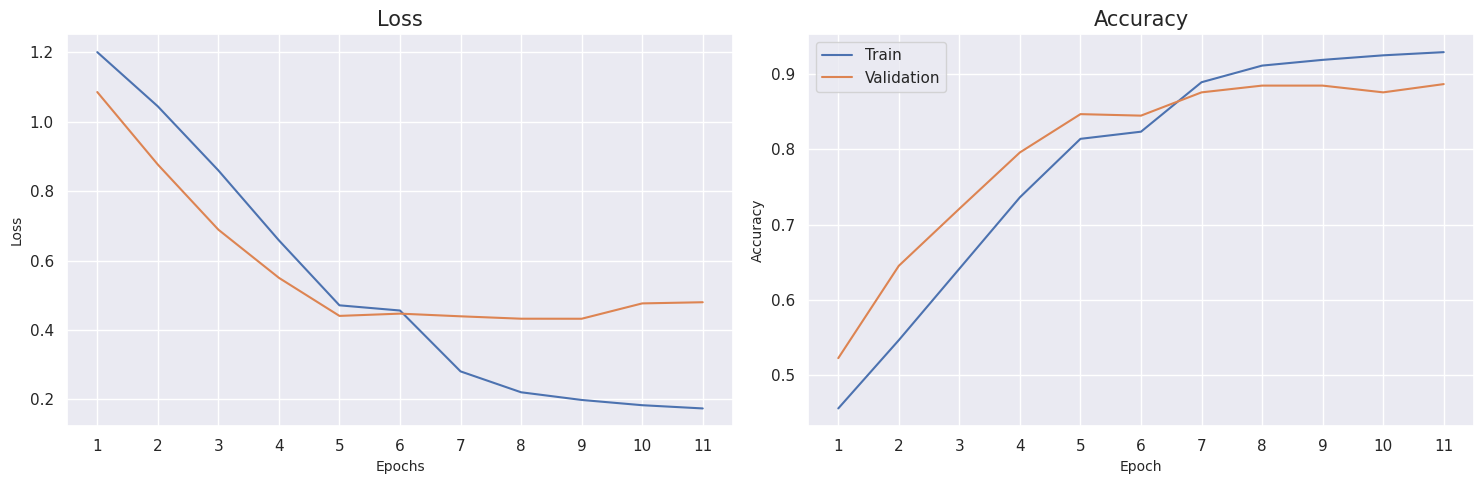

In [137]:
plot_results(history9.history['loss'], history9.history['accuracy'], history9.history['val_loss'], history9.history['val_accuracy'])

In [144]:
early_stopping10 = EarlyStopping(monitor = 'val_loss', patience = 2)

In [145]:
model10 = Sequential()

In [146]:
model10.add(Embedding(vocab_size, 100, embeddings_initializer = Constant(embedding_vectors), trainable = False))
model10.add(Bidirectional(LSTM(300)))
model10.add(BatchNormalization())
model10.add(Dense(4, activation = 'softmax'))

In [147]:
model10.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [148]:
history10 = model10.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 100, callbacks = [early_stopping10], batch_size = 64)

Epoch 1/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 29s 39ms/step - accuracy: 0.4241 - loss: 1.2899 - val_accuracy: 0.2650 - val_loss: 24.0679
Epoch 2/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.5322 - loss: 1.1166 - val_accuracy: 0.6010 - val_loss: 0.9288
Epoch 3/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.6035 - loss: 0.9445 - val_accuracy: 0.7040 - val_loss: 0.7720
Epoch 4/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.6860 - loss: 0.7725 - val_accuracy: 0.7650 - val_loss: 0.6179
Epoch 5/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.7583 - loss: 0.6088 - val_accuracy: 0.8150 - val_loss: 0.5049
Epoch 6/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.8214 - loss: 0.4647 - val_accuracy: 0.8510 - val_loss: 0.4336
Epoch 7/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.8067 - loss: 0.4886 - val_accuracy: 0.4360 - val_loss: 2.8503
Epoch 8/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.7984 - loss: 

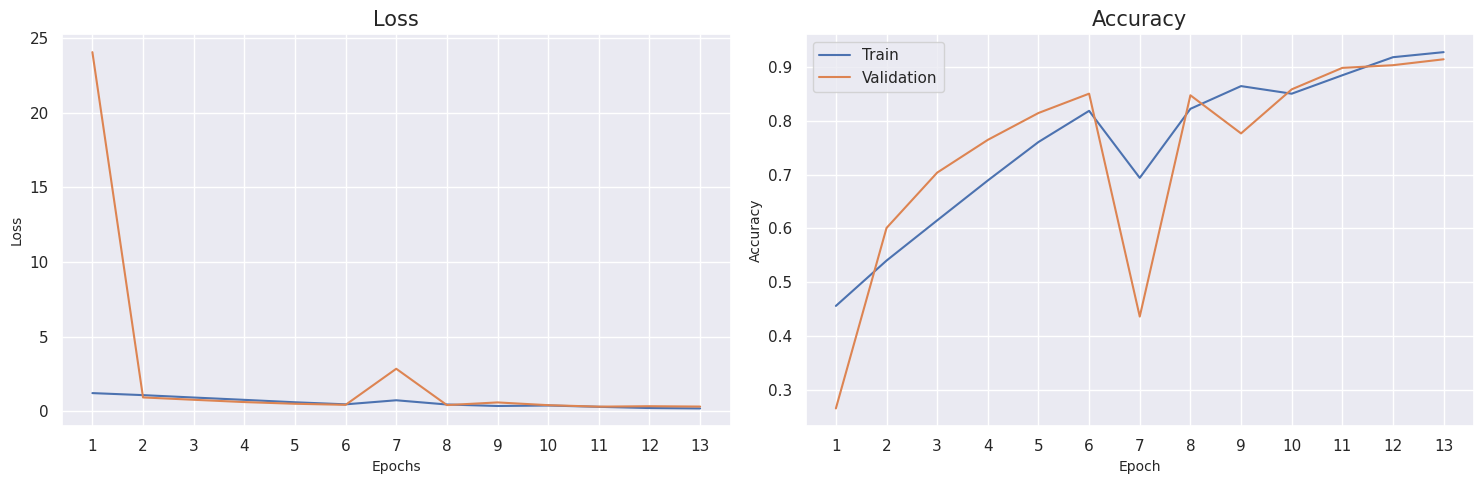

In [149]:
plot_results(history10.history['loss'], history10.history['accuracy'], history10.history['val_loss'], history10.history['val_accuracy'])

In [150]:
early_stopping11 = EarlyStopping(monitor = 'val_loss', patience = 2)

In [151]:
model11 = Sequential()

In [152]:
model11.add(Embedding(vocab_size, 100, embeddings_initializer = Constant(embedding_vectors), trainable = False))
model11.add(Bidirectional(LSTM(300)))
model11.add(Dropout(0.5))
model11.add(Dense(4, activation = 'softmax'))

In [153]:
model11.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [154]:
history11 = model11.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 100, callbacks = [early_stopping11], batch_size = 64)

Epoch 1/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.4057 - loss: 1.2699 - val_accuracy: 0.5080 - val_loss: 1.1237
Epoch 2/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.4950 - loss: 1.1333 - val_accuracy: 0.5850 - val_loss: 0.9806
Epoch 3/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.5573 - loss: 1.0228 - val_accuracy: 0.5130 - val_loss: 1.1428
Epoch 4/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.5654 - loss: 1.0125 - val_accuracy: 0.6470 - val_loss: 0.8281
Epoch 5/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.6587 - loss: 0.8204 - val_accuracy: 0.7500 - val_loss: 0.6638
Epoch 6/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.7187 - loss: 0.6975 - val_accuracy: 0.7890 - val_loss: 0.5715
Epoch 7/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.7608 - loss: 0.5959 - val_accuracy: 0.8220 - val_loss: 0.5045
Epoch 8/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.8069 - loss: 0

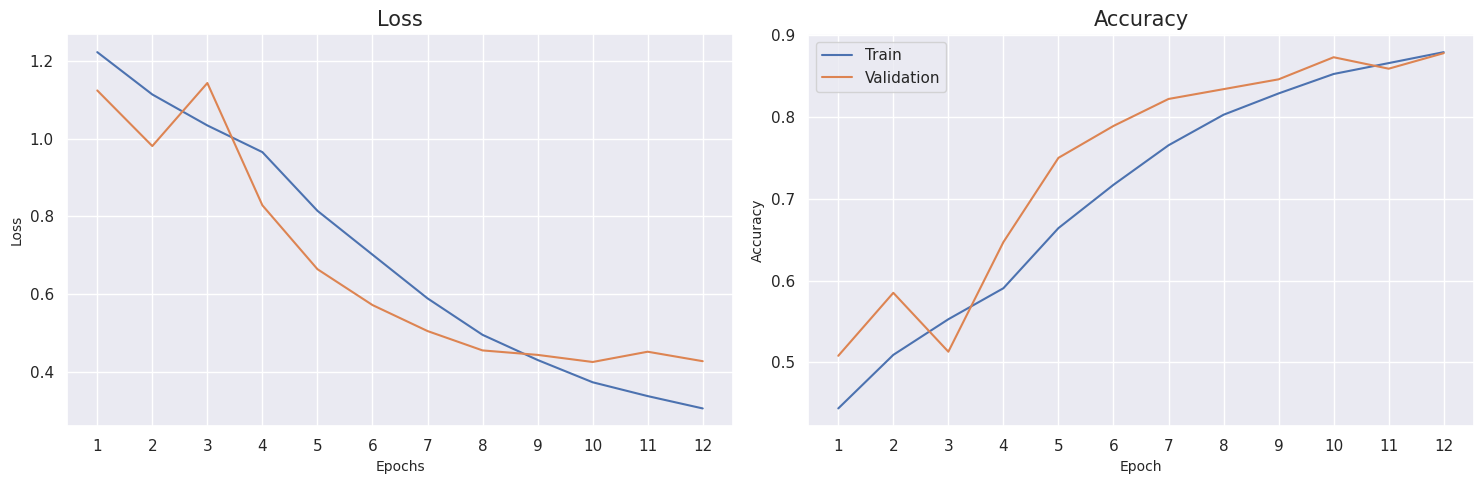

In [155]:
plot_results(history11.history['loss'], history11.history['accuracy'], history11.history['val_loss'], history11.history['val_accuracy'])

In [161]:
early_stopping12 = EarlyStopping(monitor = 'val_loss', patience = 2)

In [162]:
model12 = Sequential()

In [163]:
model12.add(Embedding(vocab_size, 100, embeddings_initializer = Constant(embedding_vectors), trainable = False))
model12.add(Bidirectional(LSTM(300)))
model12.add(BatchNormalization())
model12.add(Dropout(0.50))
model12.add(Dense(4, activation = 'softmax'))

In [164]:
model12.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [165]:
history12 = model12.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 100, callbacks = [early_stopping12], batch_size = 64)

Epoch 1/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - accuracy: 0.3896 - loss: 1.4211 - val_accuracy: 0.4660 - val_loss: 1.1758
Epoch 2/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.4854 - loss: 1.1617 - val_accuracy: 0.5440 - val_loss: 1.0528
Epoch 3/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.5232 - loss: 1.0872 - val_accuracy: 0.5550 - val_loss: 1.0201
Epoch 4/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.5645 - loss: 1.0208 - val_accuracy: 0.3170 - val_loss: 2.0938
Epoch 5/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.6107 - loss: 0.9280 - val_accuracy: 0.5900 - val_loss: 0.9745
Epoch 6/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - accuracy: 0.6601 - loss: 0.8261 - val_accuracy: 0.7510 - val_loss: 0.6642
Epoch 7/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.7053 - loss: 0.7247 - val_accuracy: 0.7710 - val_loss: 0.5977
Epoch 8/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.7530 - loss: 0

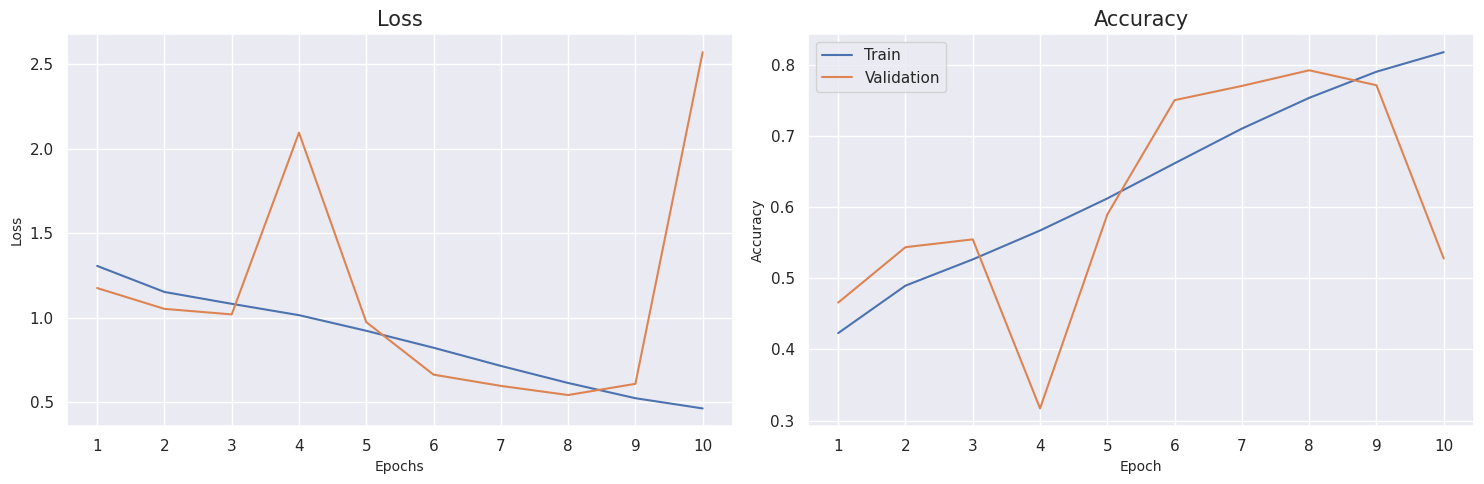

In [167]:
plot_results(history12.history['loss'], history12.history['accuracy'], history12.history['val_loss'], history12.history['val_accuracy'])

In [174]:
early_stopping13 = EarlyStopping(monitor = 'val_loss', patience = 2)

In [175]:
model13 = Sequential()

In [176]:
model13.add(Embedding(vocab_size, 100, embeddings_initializer = Constant(embedding_vectors), trainable = False))
model13.add(Bidirectional(LSTM(300, kernel_regularizer = l1(0.01))))
model13.add(Dense(4, activation = 'softmax'))

In [177]:
model13.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [178]:
history13 = model13.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 100, callbacks = [early_stopping13], batch_size = 64)

Epoch 1/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 29s 39ms/step - accuracy: 0.2788 - loss: 14.1323 - val_accuracy: 0.2810 - val_loss: 1.6770
Epoch 2/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.2821 - loss: 1.6812 - val_accuracy: 0.2660 - val_loss: 1.7072
Epoch 3/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.2510 - loss: 1.6793 - val_accuracy: 0.1720 - val_loss: 1.7078


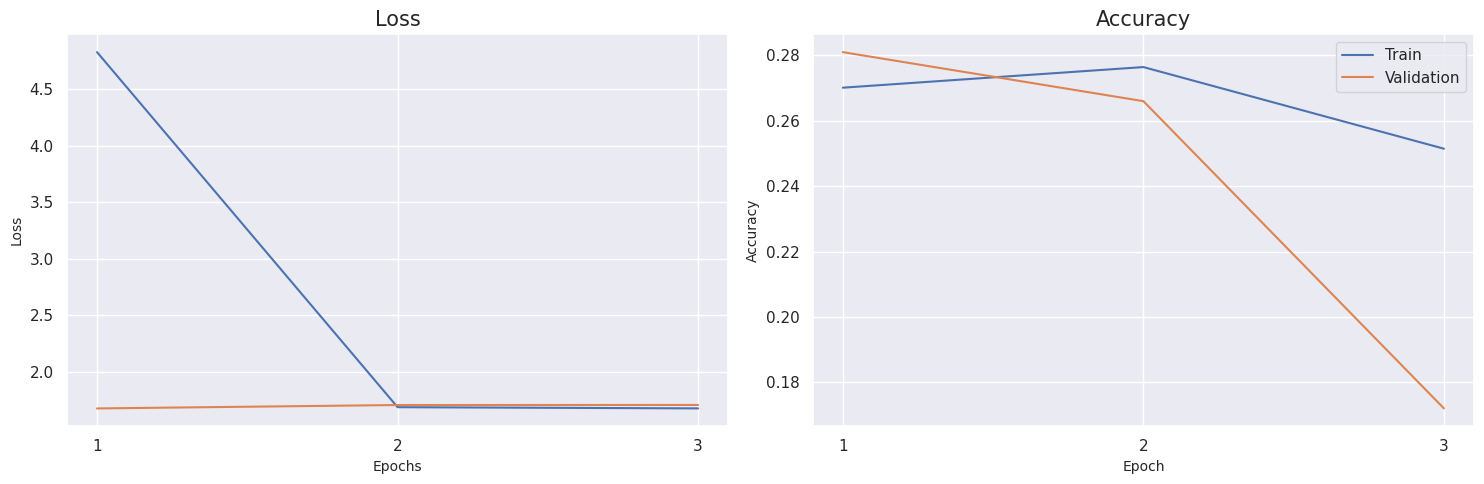

In [179]:
plot_results(history13.history['loss'], history13.history['accuracy'], history13.history['val_loss'], history13.history['val_accuracy'])

In [195]:
early_stopping14_3 = EarlyStopping(monitor = 'val_loss', patience = 2)

In [196]:
model14 = Sequential()

In [197]:
model14.add(Embedding(vocab_size, 100, embeddings_initializer = Constant(embedding_vectors), trainable = False))
model14.add(Bidirectional(LSTM(300)))
model14.add(BatchNormalization())
model14.add(Dense(4, activation = 'softmax', kernel_regularizer = l1(0.01)))

In [198]:
model14.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
history14 = model14.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 100, callbacks = [early_stopping14_2], batch_size = 64)

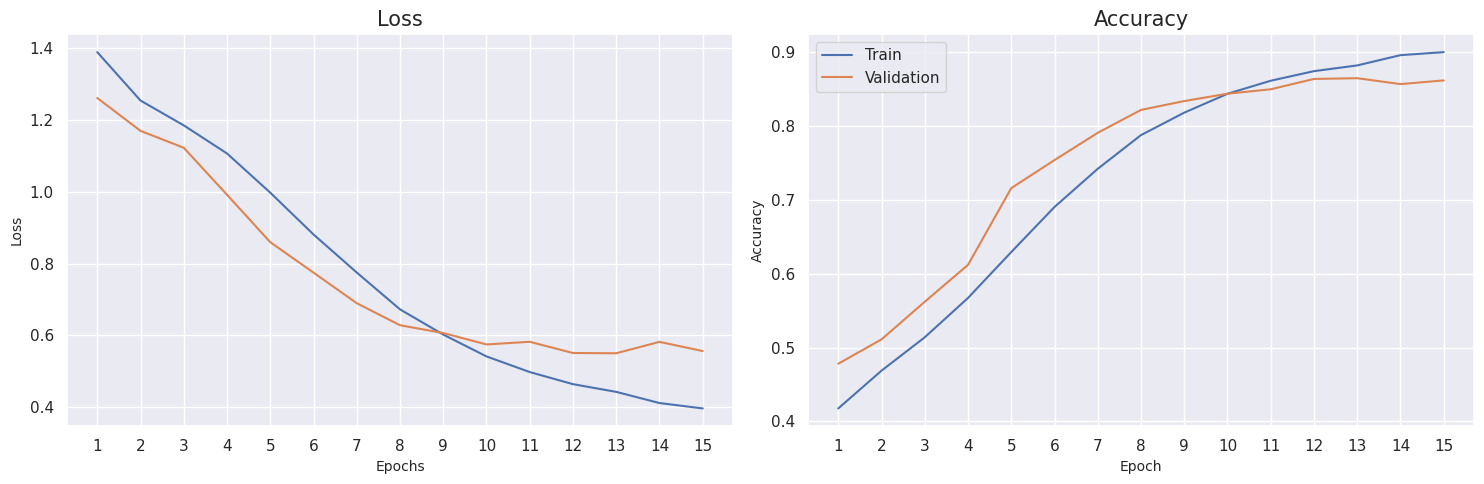

In [194]:
plot_results(history14.history['loss'], history14.history['accuracy'], history14.history['val_loss'], history14.history['val_accuracy'])

In [63]:
early_stopping15 = EarlyStopping(monitor = 'val_loss', patience = 2)

In [64]:
model15 = Sequential()

In [65]:
model15.add(Embedding(vocab_size, 100, embeddings_initializer = Constant(embedding_vectors), trainable = False))
model15.add(Bidirectional(LSTM(300)))
model15.add(BatchNormalization())
model15.add(Dense(4, activation = 'softmax', kernel_regularizer = l2(0.01)))

I0000 00:00:1744368756.178428      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744368756.179198      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [66]:
model15.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [67]:
history14 = model15.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 100, callbacks = [early_stopping15], batch_size = 64)

Epoch 1/100


I0000 00:00:1744368768.987030      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


627/627 ━━━━━━━━━━━━━━━━━━━━ 31s 34ms/step - accuracy: 0.4188 - loss: 1.3304 - val_accuracy: 0.5140 - val_loss: 1.1176
Epoch 2/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.5288 - loss: 1.0972 - val_accuracy: 0.6190 - val_loss: 0.9178
Epoch 3/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.6061 - loss: 0.9610 - val_accuracy: 0.6950 - val_loss: 0.8070
Epoch 4/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.6779 - loss: 0.8145 - val_accuracy: 0.7660 - val_loss: 0.6498
Epoch 5/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.7559 - loss: 0.6556 - val_accuracy: 0.8170 - val_loss: 0.5301
Epoch 6/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.8173 - loss: 0.5138 - val_accuracy: 0.8470 - val_loss: 0.4475
Epoch 7/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.8618 - loss: 0.4121 - val_accuracy: 0.8730 - val_loss: 0.4084
Epoch 8/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.8895 - loss: 0.3457 - val_

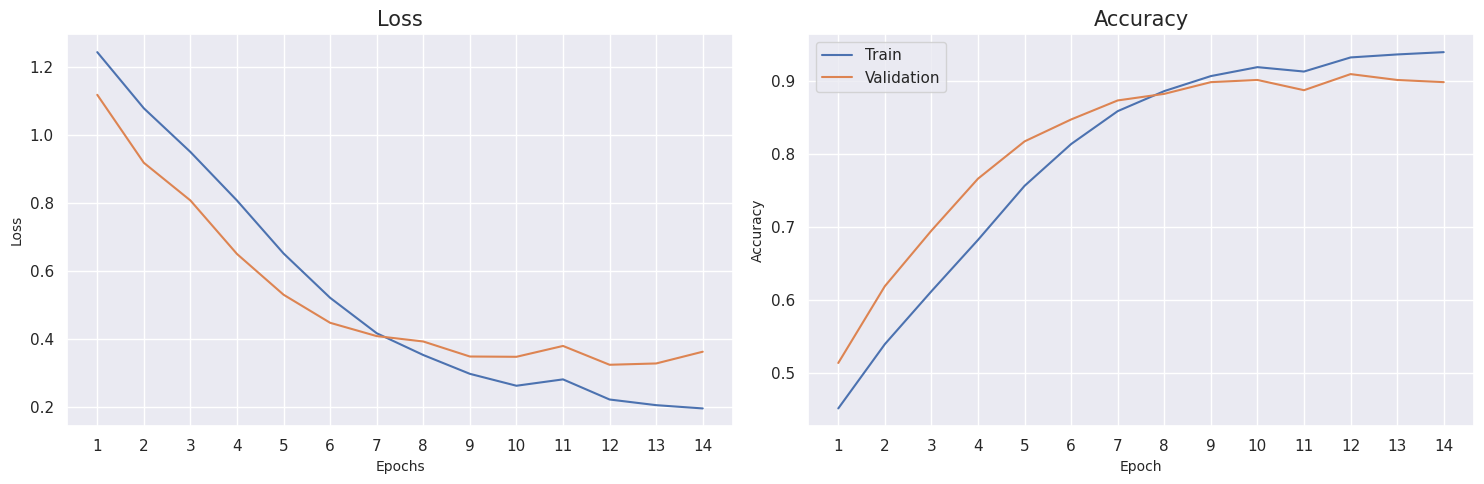

In [68]:
plot_results(history14.history['loss'], history14.history['accuracy'], history14.history['val_loss'], history14.history['val_accuracy'])

In [69]:
early_stopping16 = EarlyStopping(monitor = 'val_loss', patience = 2)

In [70]:
model16 = Sequential()

In [71]:
model16.add(Embedding(vocab_size, 100, embeddings_initializer = Constant(embedding_vectors), trainable = False))
model16.add(Bidirectional(LSTM(300)))
model16.add(BatchNormalization())
model16.add(Dense(4, activation = 'softmax'))

In [72]:
model16.compile(
    optimizer = 'SGD',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [73]:
history16 = model16.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 100, callbacks = [early_stopping16], batch_size = 64)

Epoch 1/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 27s 37ms/step - accuracy: 0.3849 - loss: 1.3186 - val_accuracy: 0.4360 - val_loss: 1.2565
Epoch 2/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.4479 - loss: 1.2179 - val_accuracy: 0.4960 - val_loss: 1.1828
Epoch 3/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.4578 - loss: 1.2000 - val_accuracy: 0.4890 - val_loss: 1.1822
Epoch 4/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.4712 - loss: 1.1878 - val_accuracy: 0.4860 - val_loss: 1.1757
Epoch 5/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.4790 - loss: 1.1710 - val_accuracy: 0.5040 - val_loss: 1.1494
Epoch 6/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.4796 - loss: 1.1647 - val_accuracy: 0.4830 - val_loss: 1.1805
Epoch 7/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.4874 - loss: 1.1521 - val_accuracy: 0.5130 - val_loss: 1.1273
Epoch 8/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.5064 - loss: 1

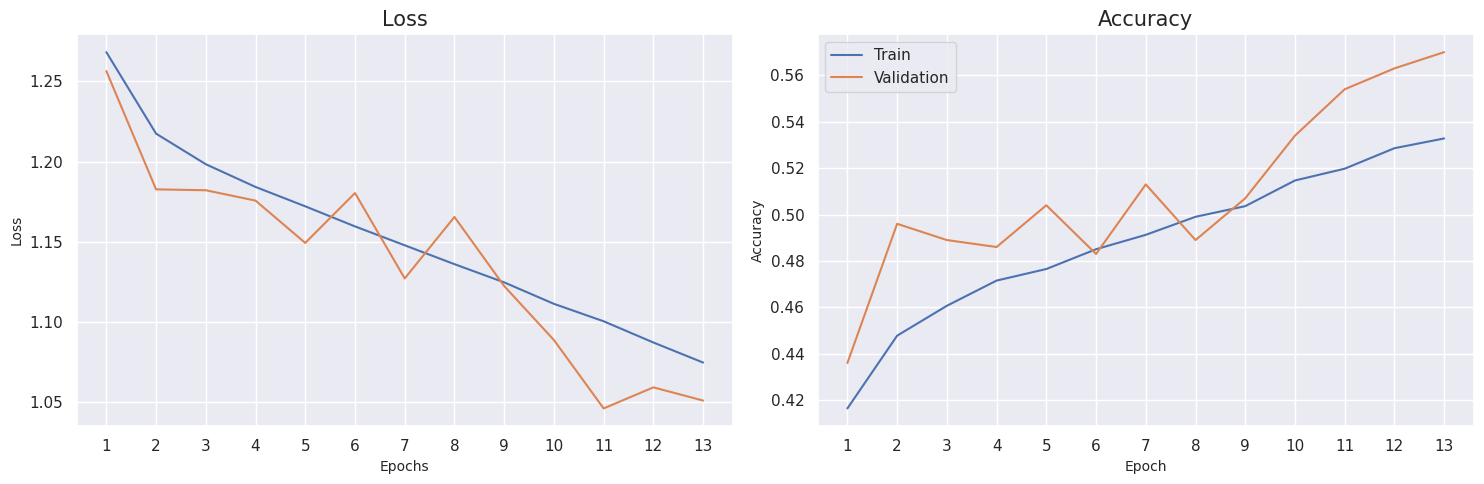

In [74]:
plot_results(history16.history['loss'], history16.history['accuracy'], history16.history['val_loss'], history16.history['val_accuracy'])

In [81]:
early_stopping17 = EarlyStopping(monitor = 'val_loss', patience = 2)

In [82]:
model17 = Sequential()

In [83]:
model17.add(Embedding(vocab_size, 100, embeddings_initializer = Constant(embedding_vectors), trainable = False))
model17.add(Bidirectional(LSTM(300)))
model17.add(BatchNormalization())
model17.add(Dense(4, activation = 'softmax'))

In [84]:
model17.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [85]:
history17 = model17.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 100, callbacks = [early_stopping17], batch_size = 32)

Epoch 1/100
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 37s 26ms/step - accuracy: 0.4221 - loss: 1.3046 - val_accuracy: 0.5270 - val_loss: 1.0882
Epoch 2/100
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.5401 - loss: 1.0768 - val_accuracy: 0.6270 - val_loss: 0.8923
Epoch 3/100
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.6238 - loss: 0.9073 - val_accuracy: 0.7110 - val_loss: 0.7172
Epoch 4/100
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.7107 - loss: 0.7220 - val_accuracy: 0.7960 - val_loss: 0.5315
Epoch 5/100
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.7899 - loss: 0.5415 - val_accuracy: 0.8520 - val_loss: 0.4245
Epoch 6/100
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.8501 - loss: 0.3932 - val_accuracy: 0.8710 - val_loss: 0.4072
Epoch 7/100
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.8854 - loss: 0.3093 - val_accuracy: 0.8970 - val_loss: 0.3270
Epoch 8/100
1254/1254 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 

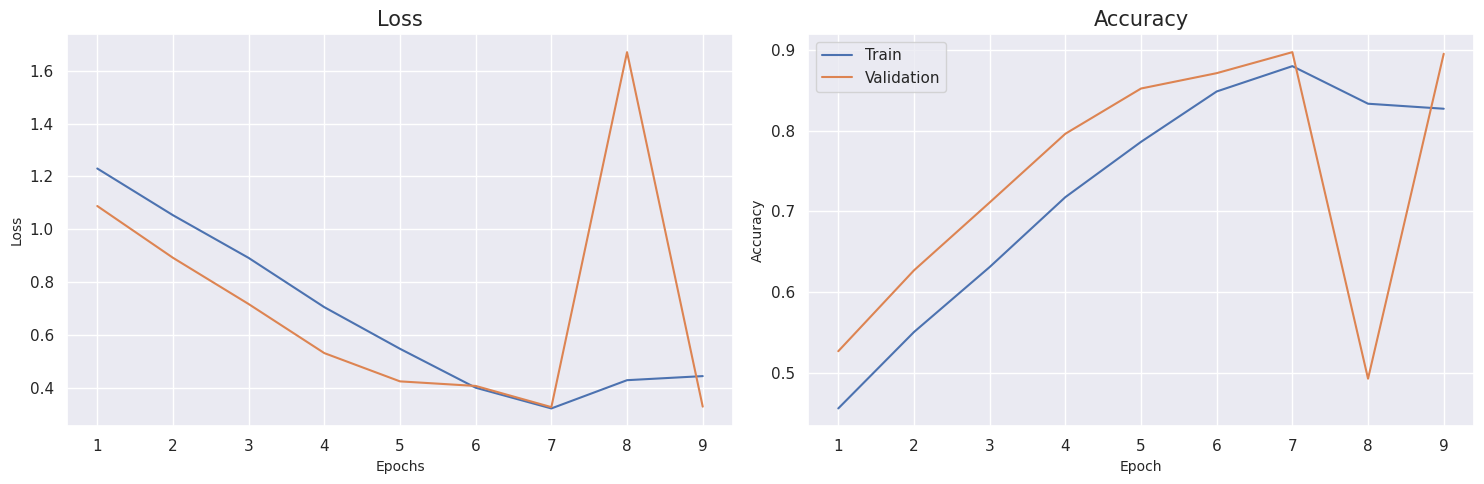

In [86]:
plot_results(history17.history['loss'], history17.history['accuracy'], history17.history['val_loss'], history17.history['val_accuracy'])

In [87]:
early_stopping18 = EarlyStopping(monitor = 'val_loss', patience = 2)

In [88]:
model18 = Sequential()

In [89]:
model18.add(Embedding(vocab_size, 100, embeddings_initializer = Constant(embedding_vectors), trainable = False))
model18.add(Bidirectional(LSTM(300)))
model18.add(BatchNormalization())
model18.add(Dense(4, activation = 'softmax'))

In [90]:
model18.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [91]:
history17 = model18.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 100, callbacks = [early_stopping18], batch_size = 128)

Epoch 1/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 25s 65ms/step - accuracy: 0.4128 - loss: 1.3050 - val_accuracy: 0.2850 - val_loss: 4.6765
Epoch 2/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - accuracy: 0.5324 - loss: 1.0809 - val_accuracy: 0.4980 - val_loss: 1.1604
Epoch 3/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accuracy: 0.5927 - loss: 0.9710 - val_accuracy: 0.6540 - val_loss: 0.8264
Epoch 4/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - accuracy: 0.6548 - loss: 0.8359 - val_accuracy: 0.7280 - val_loss: 0.6924
Epoch 5/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accuracy: 0.7222 - loss: 0.6929 - val_accuracy: 0.7650 - val_loss: 0.6273
Epoch 6/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accuracy: 0.7780 - loss: 0.5625 - val_accuracy: 0.8080 - val_loss: 0.5253
Epoch 7/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accuracy: 0.8316 - loss: 0.4395 - val_accuracy: 0.8440 - val_loss: 0.4428
Epoch 8/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accuracy: 0.8680 - loss: 0

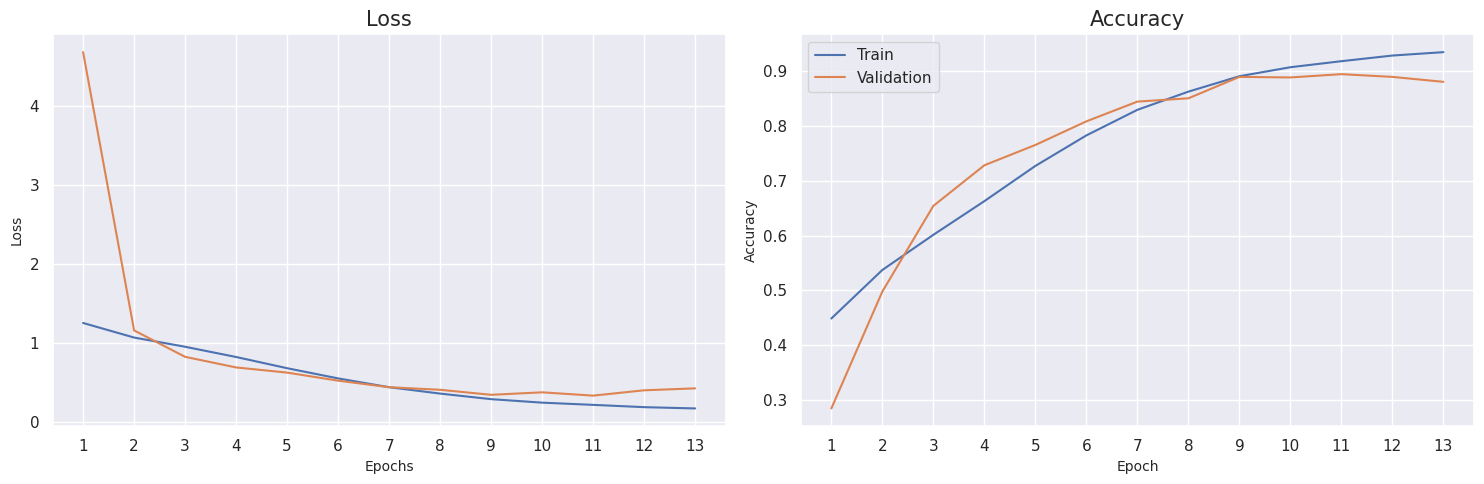

In [93]:
plot_results(history17.history['loss'], history17.history['accuracy'], history17.history['val_loss'], history17.history['val_accuracy'])

In [99]:
early_stopping19 = EarlyStopping(monitor = 'val_loss', patience = 2)

In [100]:
model19 = Sequential()

In [101]:
model19.add(Embedding(vocab_size, 100, embeddings_initializer = Constant(embedding_vectors), trainable = False))
model19.add(Bidirectional(LSTM(300)))
model19.add(BatchNormalization())
model19.add(Dense(4, activation = 'softmax'))

In [102]:
model19.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [103]:
history19 = model19.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 100, callbacks = [early_stopping19], batch_size = 64)

Epoch 1/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.4222 - loss: 1.2960 - val_accuracy: 0.2770 - val_loss: 26.1146
Epoch 2/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.5406 - loss: 1.0672 - val_accuracy: 0.6490 - val_loss: 0.8845
Epoch 3/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.6147 - loss: 0.9239 - val_accuracy: 0.7020 - val_loss: 0.7705
Epoch 4/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 23s 36ms/step - accuracy: 0.6983 - loss: 0.7553 - val_accuracy: 0.7510 - val_loss: 0.6342
Epoch 5/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.7700 - loss: 0.5959 - val_accuracy: 0.8050 - val_loss: 0.5219
Epoch 6/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.8256 - loss: 0.4586 - val_accuracy: 0.8580 - val_loss: 0.4074
Epoch 7/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.8721 - loss: 0.3484 - val_accuracy: 0.8730 - val_loss: 0.3738
Epoch 8/100
627/627 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.9000 - loss: 

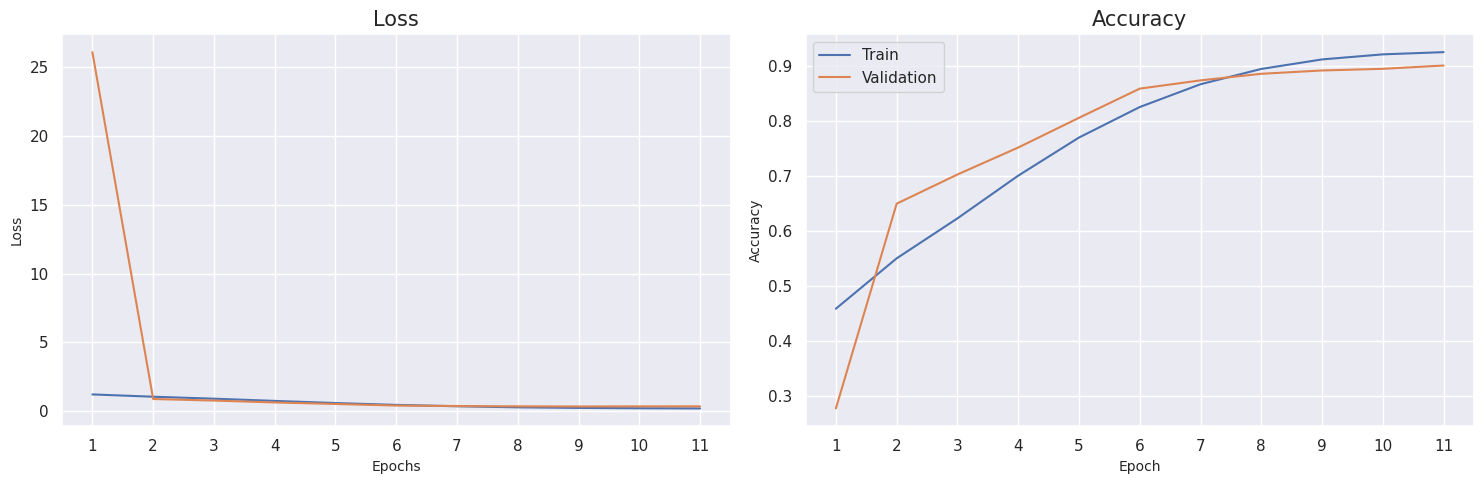

In [104]:
plot_results(history19.history['loss'], history19.history['accuracy'], history19.history['val_loss'], history19.history['val_accuracy'])

In [106]:
model19.evaluate(X_test, y_test)

314/314 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7795 - loss: 0.7580


[0.7570863366127014, 0.7797607183456421]

In [107]:
y_pred = model19.predict(X_test)

314/314 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


In [110]:
y_test

array([0, 1, 0, ..., 1, 3, 1])

In [111]:
y_pred

array([[9.9968505e-01, 2.4889084e-07, 2.4214210e-05, 2.9052887e-04],
       [9.3934936e-08, 9.9415451e-01, 7.0228994e-06, 5.8383159e-03],
       [9.9913269e-01, 5.2722917e-06, 8.1810652e-04, 4.3985001e-05],
       ...,
       [2.3612192e-04, 9.8207766e-01, 4.2694570e-03, 1.3416722e-02],
       [1.3642975e-03, 3.3482566e-02, 3.9381396e-02, 9.2577171e-01],
       [1.2126212e-08, 9.9997258e-01, 5.2188149e-08, 2.7314116e-05]],
      dtype=float32)

In [112]:
y_p = [np.argmax(i) for i in y_pred]

In [113]:
print(classification_report(y_test, y_p))

              precision    recall  f1-score   support

           0       0.82      0.79      0.80      2507
           1       0.80      0.77      0.79      2508
           2       0.83      0.72      0.77      2507
           3       0.69      0.83      0.76      2508

    accuracy                           0.78     10030
   macro avg       0.79      0.78      0.78     10030
weighted avg       0.79      0.78      0.78     10030



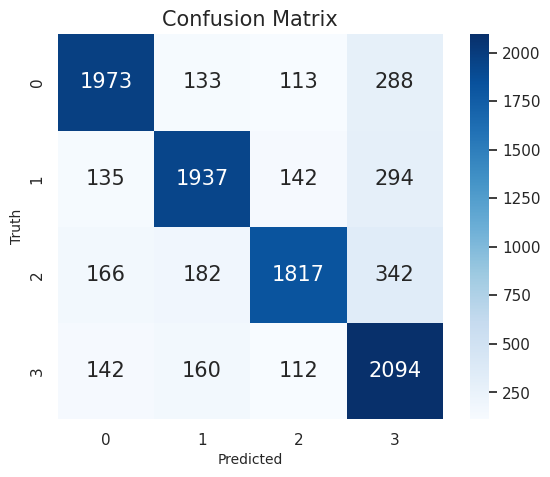

In [114]:
plt.figure(figsize = (7, 5))
sns.heatmap(confusion_matrix(y_test, y_p), annot = True, square = True, cbar = True, annot_kws = {'size': 15}, fmt = 'd', cmap = 'Blues')
plt.title('Confusion Matrix', fontsize = 15)
plt.xlabel('Predicted', fontsize = 10)
plt.ylabel('Truth', fontsize = 10)
plt.show()

In [127]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import trange

In [139]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')  

In [140]:
print(f'Using {device} device')

Using cuda device


In [120]:
class PaddedTextDataset(Dataset):
    def __init__(self, padded_sequences, labels):
        self.padded_sequences = padded_sequences
        self.labels = labels


    def __len__(self):
        return len(self.labels)


    def __getitem__(self, index):
        return self.padded_sequences[index], self.labels[index]

In [121]:
train_dataset = PaddedTextDataset(X_train, y_train)
val_dataset = PaddedTextDataset(X_val, y_val)
test_dataset = PaddedTextDataset(X_test, y_test)

In [122]:
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 64, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False)

In [151]:
def train_step(model, criterion, optimizer, dataloader, device = device):
    running_loss, correct = 0, 0
    model.train()
    optimizer.zero_grad()
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    return running_loss / len(dataloader), 100 * correct / len(dataloader.dataset)

In [158]:
def val_step(model, criterion, dataloader, device  = device):
    running_loss, correct = 0, 0
    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            running_loss += criterion(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    return running_loss / len(dataloader), 100 * correct / len(dataloader.dataset)

In [159]:
def train_model(model, n_epochs, optimizer, train_loader, val_loader, device = device):
    criterion = nn.CrossEntropyLoss()
    train_accs, train_losses = [], []
    val_accs, val_losses = [], []
    for _ in (pbar := trange(n_epochs)):
        train_loss, train_acc = train_step(model, criterion, optimizer, train_loader, device)
        val_loss, val_acc = val_step(model, criterion, val_loader, device)
        pbar.set_description(f'Train Loss: {train_loss:.3f} | Val Loss: {val_loss:.3f} | Train Acc: {train_acc:.2f} | Val Acc: {val_acc:.2f}')
        train_accs.append(train_acc)
        train_losses.append(train_loss)
        val_accs.append(val_acc)
        val_losses.append(val_loss)
    plot_results(train_losses, train_accs, val_losses, val_accs)
    return {'train_loss': train_losses, 'train_acc': train_accs, 'val_loss': val_losses, 'val_acc': val_accs}

In [135]:
#class t_model(nn.Module):
 #   def __init__(self, vocab_size, embedding_dim, embedding_vectors, hidden_units, num_classes):
  #      super(t_model, self).__init__()
   #     embedding_vectors_tensor = torch.tensor(embedding_vectors, dtype=torch.float32)
    #    self.network = nn.Sequential(nn.Embedding(vocab_size, embedding_dim).weight.data.copy_(embedding_vectors_tensor),
     #                               nn.LSTM(embedding_dim, hidden_units),
      #                              nn.Linear(hidden_units, num_classes))
#
 #   def forward(self, x):
  #      return self.network(x)

In [167]:
class t_model(nn.Module):  
    def __init__(self, vocab_size, embedding_dim, embedding_vectors, hidden_units, num_classes):  
        super(t_model, self).__init__()  

        # Create an embedding layer and set weights from a numpy array  
        self.embedding = nn.Embedding(vocab_size, embedding_dim)  
        self.embedding.weight.data.copy_(torch.tensor(embedding_vectors, dtype=torch.float32))  

        # Define the LSTM and Linear layers  
        self.lstm = nn.LSTM(embedding_dim, hidden_units, batch_first=True, bidirectional = True)  
        self.batch_norm = nn.BatchNorm1d(hidden_units * 2)
        self.fc = nn.Linear(hidden_units * 2, num_classes)  

        # Combine the layers in a sequential-like manner for forward pass  
        self.network = nn.Sequential(  
            self.embedding,  
            self.lstm,  
            self.fc  
        )  

    def forward(self, x):  
        x = self.embedding(x)  # Apply embedding layer  
        x, _ = self.lstm(x)    # Pass through LSTM  
        
        # Get the output from the LSTM (last hidden state)  
        x = x[:, -1, :]  # Take the last time step  
        x = self.batch_norm(x)
        x = self.fc(x)   # Apply the fully connected layer  
        return x

Train Loss: 0.086 | Val Loss: 0.336 | Train Acc: 96.48 | Val Acc: 90.90: 100%|██████████| 20/20 [07:16<00:00, 21.82s/it]


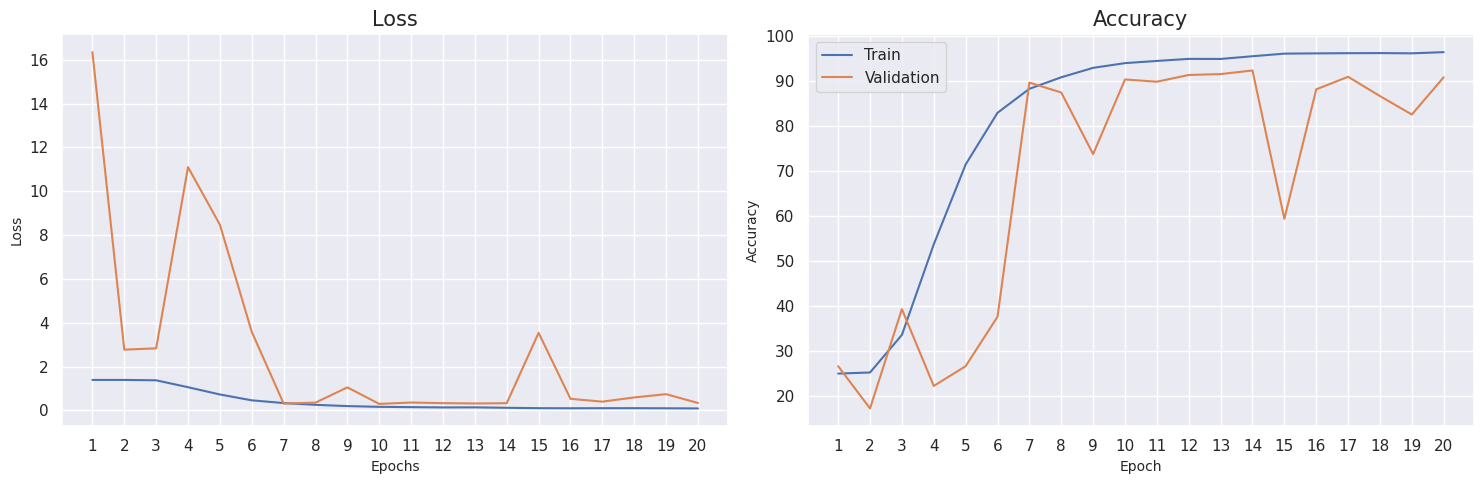

In [169]:
model = t_model(vocab_size = vocab_size, embedding_dim = 100, embedding_vectors = embedding_vectors, hidden_units = 300, num_classes = 4).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
results = train_model(model, 20, optimizer, train_loader, val_loader)

In [30]:
import keras_nlp
import tensorflow as tf

In [31]:
df_b.head()

,0,1,sentiment,text,cleaned_text
0,2418,Borderlands,Irrelevant,Appreciate the (sonic) concepts / praxis Valen...,appreci sonic concept praxi valenzuela landapo...
1,2418,Borderlands,Irrelevant,Appreciate the (sound) concepts / practices th...,appreci sound concept practic valenzuela landa...
2,2418,Borderlands,Irrelevant,Evaluate the (sound) concepts / concepts of Va...,evalu sound concept concept valensela landa po...
3,2418,Borderlands,Irrelevant,Appreciate the (sonic) concepts / praxis Valen...,appreci sonic concept praxi valenzuela morenop...
4,2418,Borderlands,Irrelevant,Appreciate by the ( sonic ) electronic concept...,appreci sonic electron concept praxi valenzuel...


In [32]:
le3 = LabelEncoder()

In [33]:
df_b['label'] = le3.fit_transform(df_b['sentiment'])

In [34]:
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(df_b['cleaned_text'], df_b['label'], test_size = 0.2, random_state = 101, shuffle = True, stratify = df_b['label'])

In [35]:
X_train_ragged = tf.ragged.constant(X_train_n)

I0000 00:00:1744469205.301641      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744469205.302308      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [36]:
X_train_tensor = tf.convert_to_tensor(X_train_ragged)

In [37]:
train_data = tf.data.Dataset.from_tensor_slices((X_train_tensor, y_train_n))

In [47]:
df_val.head()

,0,1,sentiment,text,cleaned_text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...,mention facebook struggl motiv go run day tran...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...,bbc news amazon boss jeff bezo reject claim co...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...,microsoft pay word function poorli samsungu ch...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,...",csgo matchmak full closet hack truli aw game
4,4433,Google,Neutral,Now the President is slapping Americans in the...,presid slap american face realli commit unlaw ...


In [48]:
X_val_ragged = tf.ragged.constant(df_val['cleaned_text'])

In [49]:
X_val_tensor = tf.convert_to_tensor(X_val_ragged)

In [50]:
y_val2 = le3.fit_transform(df_val['sentiment'])

In [51]:
val_data = tf.data.Dataset.from_tensor_slices((X_val_tensor, y_val2))

In [52]:
X_test_ragged = tf.ragged.constant(X_test_n)

In [53]:
X_test_tensor = tf.convert_to_tensor(X_test_ragged)

In [54]:
test_data = tf.data.Dataset.from_tensor_slices((X_test_tensor, y_test_n))

In [55]:
train_data = train_data.cache().shuffle(len(X_train_n)).batch(8).prefetch(tf.data.AUTOTUNE)
val_data = val_data.cache().shuffle(1000).batch(8).prefetch(tf.data.AUTOTUNE)
test_data = test_data.cache().shuffle(len(X_test_n)).batch(8).prefetch(tf.data.AUTOTUNE)

In [56]:
tokenizer2 = keras_nlp.models.BertTokenizer.from_preset('bert_small_en_uncased')

In [57]:
preprocessor = keras_nlp.models.BertPreprocessor(
    tokenizer2, sequence_length = 80, truncate = 'round_robin'
)

In [58]:
bert_model = keras_nlp.models.BertClassifier.from_preset(
    'bert_small_en_uncased', preprocessor = preprocessor, num_classes = 4
)

In [59]:
bert_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy']
)

In [60]:
early_stopping100 = EarlyStopping(monitor = 'val_loss', patience = 2)

In [61]:
history100 = bert_model.fit(train_data, validation_data = val_data, epochs = 30, callbacks = [early_stopping100])

Epoch 1/30


I0000 00:00:1744469361.053598     101 service.cc:148] XLA service 0x7877000045a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744469361.054538     101 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1744469361.054559     101 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1744469362.690761     101 cuda_dnn.cc:529] Loaded cuDNN version 90300


   3/5015 ━━━━━━━━━━━━━━━━━━━━ 3:51 46ms/step - accuracy: 0.2569 - loss: 1.4013   

I0000 00:00:1744469373.796512     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5015/5015 ━━━━━━━━━━━━━━━━━━━━ 214s 37ms/step - accuracy: 0.4269 - loss: 1.2382 - val_accuracy: 0.6650 - val_loss: 0.8422
Epoch 2/30
5015/5015 ━━━━━━━━━━━━━━━━━━━━ 170s 34ms/step - accuracy: 0.6339 - loss: 0.9054 - val_accuracy: 0.7660 - val_loss: 0.6441
Epoch 3/30
5015/5015 ━━━━━━━━━━━━━━━━━━━━ 172s 34ms/step - accuracy: 0.7278 - loss: 0.7070 - val_accuracy: 0.8460 - val_loss: 0.4627
Epoch 4/30
5015/5015 ━━━━━━━━━━━━━━━━━━━━ 172s 34ms/step - accuracy: 0.8006 - loss: 0.5327 - val_accuracy: 0.8840 - val_loss: 0.3760
Epoch 5/30
5015/5015 ━━━━━━━━━━━━━━━━━━━━ 172s 34ms/step - accuracy: 0.8459 - loss: 0.4146 - val_accuracy: 0.9040 - val_loss: 0.3018
Epoch 6/30
5015/5015 ━━━━━━━━━━━━━━━━━━━━ 172s 34ms/step - accuracy: 0.8799 - loss: 0.3187 - val_accuracy: 0.9170 - val_loss: 0.2998
Epoch 7/30
5015/5015 ━━━━━━━━━━━━━━━━━━━━ 172s 34ms/step - accuracy: 0.9029 - loss: 0.2555 - val_accuracy: 0.9160 - val_loss: 0.2578
Epoch 8/30
5015/5015 ━━━━━━━━━━━━━━━━━━━━ 172s 34ms/step - accuracy: 0.9174 - lo

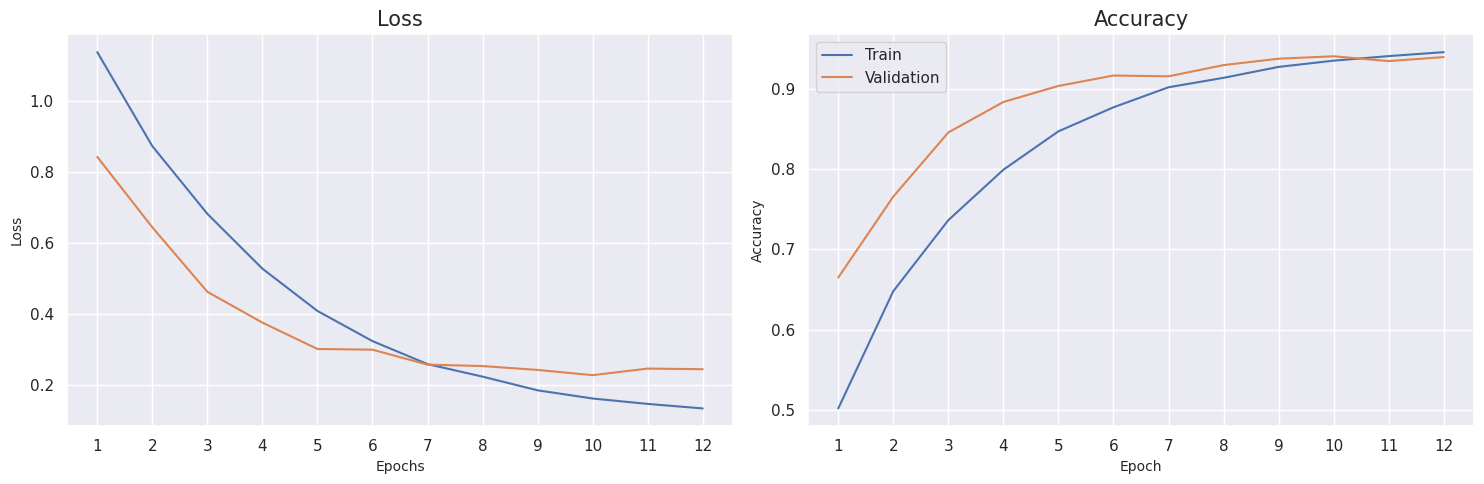

In [63]:
plot_results(history100.history['loss'], history100.history['accuracy'], history100.history['val_loss'], history100.history['val_accuracy'])

In [64]:
bert_model.evaluate(test_data)

1254/1254 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8572 - loss: 0.5001


[0.4991167187690735, 0.859122633934021]